# GAUZY 

In [1]:
# -*- coding: utf-8 -*-

"""
importing all the neccessary libraries
@author: Steven 
@affiliation: UoA, DICP

"""

'\nimporting all the neccessary libraries\n@author: Steven \n@affiliation: UoA\n\n'

## Part 1 Calculate the fitness for training

### 1.1 Randomly generate structures for training

In [2]:
import numpy as np
from population import Population
import ase.db
from ase import Atoms
from ase.data import atomic_numbers
from ase.io import read, write
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ

from ase.ga import get_raw_score
from ase.ga.data import PrepareDB
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.startgenerator import StartGenerator
from ase.ga.data import DataConnection
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.ga.data import PrepareDB

# Number of random initial structures to generate
N = 20

# Target cell volume for the initial structures, in angstrom^3
volume = 400.

# Specify the 'building blocks' from which the initial structures
# will be constructed. Here we take single Ag atoms as building
# blocks, 24 in total.
blocks = [('C', 38)]
# We may also write:
blocks = ['C'] * 38

# Generate a dictionary with the closest allowed interatomic distances
Z = atomic_numbers['C']
blmin = closest_distances_generator(atom_numbers=[Z],
                                    ratio_of_covalent_radii=1)

# Specify reasonable bounds on the minimal and maximal
# cell vector lengths (in angstrom) and angles (in degrees)
cellbounds = CellBounds(bounds={'phi': [35, 145], 'chi': [35, 145],
                                'psi': [35, 145], 'a': [3, 50],
                                'b': [3, 50], 'c': [3, 50]})

# Choose an (optional) 'cell splitting' scheme which basically
# controls the level of translational symmetry (within the unit
# cell) of the randomly generated structures. Here a 1:1 ratio
# of splitting factors 2 and 1 is used:
splits = {(2,): 1, (1,): 1}
# There will hence be a 50% probability that a candidate
# is constructed by repeating an randomly generated Ag12
# structure along a randomly chosen axis. In the other 50%
# of cases, no cell cell splitting will be applied.

# The 'slab' object in the GA serves as a template
# in the creation of new structures, which inherit
# the slab's atomic positions (if any), cell vectors
# (if specified), and periodic boundary conditions.
# Here only the last property is relevant:
slab = Atoms('', pbc=True)

# Initialize the random structure generator
sg = StartGenerator(slab, blocks, blmin, box_volume=volume,
                    number_of_variable_cell_vectors=3,
                    cellbounds=cellbounds, splits=splits)

# we prepare three primary databases,

# da_cmpl, 
# for recording the candidates including both the unrelaxed one and also the relaxed one 
# da_ftn, 
# for recording the candidates which has been calculated the fitness
# da_rlx, 
# for recording the candidates only including the relaxed one.
 
da_cmpl = PrepareDB(db_file_name='gadb_cmpl.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)
da_ftn = PrepareDB(db_file_name='gadb_ftn.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)
da_rlx = PrepareDB(db_file_name='gadb_rlx.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)

# Generate the new structures
# and add them to the database

for i in range(N):
    a = sg.get_new_candidate()
    da_cmpl.add_unrelaxed_candidate(a)  
da_cmpl = DataConnection('gadb_cmpl.db')
write('unrelaxed_candidates.xyz', da_cmpl.get_all_unrelaxed_candidates())

### 1.2 Calculate fitness function for training 

In [3]:
from ofp_comparator import OFPComparator
from ase.ga import get_raw_score

# Various items needed for initializing the genetic operators
da_cmpl = DataConnection('gadb_cmpl.db')
da_rlx = DataConnection('gadb_rlx.db')

slab = da_cmpl.get_slab()
atom_numbers_to_optimize = da_cmpl.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 1.0)
cellbounds = CellBounds(bounds={'phi': [30, 150], 'chi': [30, 150],
                                'psi': [30, 150]})

# Relaxing the initial candidates
while da_cmpl.get_number_of_unrelaxed_candidates() > 0:
    a = da_cmpl.get_an_unrelaxed_candidate()
    a.calc = LJ()
    print('Relaxing starting candidate \n {0}'.format(a.info['confid']))
    dyn = BFGS(a, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=1000)
    a.info['key_value_pairs']['raw_score'] = -a.get_potential_energy()
    da_cmpl.add_relaxed_step(a)
    da_rlx.add_relaxed_step(a)

# compare the offspring
comp = OFPComparator(n_top=n_top, dE=1.0, cos_dist_max=5e-3, rcut=10.,
                     binwidth=0.05, pbc=[True, True, True], sigma=0.05,
                     nsigma=4, recalculate=False)
# The population
population_train = Population(data_connection=da_rlx,
                        population_size=30,
                        comparator=comp,
                        logfile='log.txt')

# calculate the fitness value and fingerprint matrix
da_ftn = ase.db.connect('gadb_ftn.db')
finger = np.zeros((1,200))

fitness_value = population_train.get_fitness(range(len(population_train.pop)), with_history=False)
get_scores = population_train.get_scores(range(len(population_train.pop)))


for i in range(len(population_train.pop)):
    print('Now starting configuration number \n {0}'.format(i), flush=True)
    print(get_raw_score(population_train.pop[i]))
    da_ftn.write(population_train.pop[i], fitness=fitness_value[i], fitted=1)
    finger_matrix = comp.take_fingerprints(population_train.pop[i])
    finger = np.append(finger, finger_matrix[0][(6,6)].reshape((1,200)), axis=0)
    
finger_train = np.delete(finger, 1, axis = 0)
print('The fitness value list \n {0}'.format(fitness_value))
print('The fingerprint matrix \n {0}'.format(finger_train))
print('The scores \n {0}'.format(get_scores))
write('relaxed_candidates.xyz', da_rlx.get_all_relaxed_candidates())

Relaxing starting candidate 
 2
Relaxing starting candidate 
 3
Relaxing starting candidate 
 4
Relaxing starting candidate 
 5
Relaxing starting candidate 
 6
Relaxing starting candidate 
 7
Relaxing starting candidate 
 8
Relaxing starting candidate 
 9
Relaxing starting candidate 
 10
Relaxing starting candidate 
 11
Relaxing starting candidate 
 12
Relaxing starting candidate 
 13
Relaxing starting candidate 
 14
Relaxing starting candidate 
 15
Relaxing starting candidate 
 16
Relaxing starting candidate 
 17
Relaxing starting candidate 
 18
Relaxing starting candidate 
 19
Relaxing starting candidate 
 20
Relaxing starting candidate 
 21
Now starting configuration number 
 0
175.85598723953623
Now starting configuration number 
 1
161.32969113957384
Now starting configuration number 
 2
157.57584038149247
Now starting configuration number 
 3
154.47773614612328
Now starting configuration number 
 4
146.74039058941807
Now starting configuration number 
 5
143.6929105582815
Now sta

## Part 2. Calculate the fitnee for testing

### 2.1 Randomly generate structures for testing

In [4]:
import numpy as np
from population import Population
import ase.db
from ase import Atoms
from ase.data import atomic_numbers
from ase.io import read, write
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ

from ase.ga import get_raw_score
from ase.ga.data import PrepareDB
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.startgenerator import StartGenerator
from ase.ga.data import DataConnection
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.ga.data import PrepareDB

# Number of random initial structures to generate
N = 20

# Target cell volume for the initial structures, in angstrom^3
volume = 400.

# Specify the 'building blocks' from which the initial structures
# will be constructed. Here we take single Ag atoms as building
# blocks, 24 in total.
blocks = [('C', 38)]
# We may also write:
blocks = ['C'] * 38

# Generate a dictionary with the closest allowed interatomic distances
Z = atomic_numbers['C']
blmin = closest_distances_generator(atom_numbers=[Z],
                                    ratio_of_covalent_radii=1)

# Specify reasonable bounds on the minimal and maximal
# cell vector lengths (in angstrom) and angles (in degrees)
cellbounds = CellBounds(bounds={'phi': [35, 145], 'chi': [35, 145],
                                'psi': [35, 145], 'a': [3, 50],
                                'b': [3, 50], 'c': [3, 50]})

# Choose an (optional) 'cell splitting' scheme which basically
# controls the level of translational symmetry (within the unit
# cell) of the randomly generated structures. Here a 1:1 ratio
# of splitting factors 2 and 1 is used:
splits = {(2,): 1, (1,): 1}
# There will hence be a 50% probability that a candidate
# is constructed by repeating an randomly generated Ag12
# structure along a randomly chosen axis. In the other 50%
# of cases, no cell cell splitting will be applied.

# The 'slab' object in the GA serves as a template
# in the creation of new structures, which inherit
# the slab's atomic positions (if any), cell vectors
# (if specified), and periodic boundary conditions.
# Here only the last property is relevant:
slab = Atoms('', pbc=True)

# Initialize the random structure generator
sg = StartGenerator(slab, blocks, blmin, box_volume=volume,
                    number_of_variable_cell_vectors=3,
                    cellbounds=cellbounds, splits=splits)


# Initialize the database
da_cmplt = PrepareDB(db_file_name='gadb_cmplt.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)
da_ftnt = PrepareDB(db_file_name='gadb_ftnt.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)
da_rlxt = PrepareDB(db_file_name='gadb_rlxt.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)
da_rlxt_ga = PrepareDB(db_file_name='gadb_rlxt_ga.db', simulation_cell=slab,
               stoichiometry=[Z] * 38)

# Generate the new structures
# and add them to the database
for i in range(N):
    a = sg.get_new_candidate()
    da_cmplt.add_unrelaxed_candidate(a)
    da_rlxt_ga.add_unrelaxed_candidate(a)
    
da_cmplt = DataConnection('gadb_cmplt.db')

write('unrelaxed_candidates_test.xyz', da_cmplt.get_all_unrelaxed_candidates())

### 2.2 Calculate fitness function for testing 

In [5]:
from ofp_comparator import OFPComparator

# Various items needed for initializing the genetic operators
da_cmplt = DataConnection('gadb_cmplt.db')
da_rlxt = DataConnection('gadb_rlxt.db')
da_rlxt_ga = DataConnection('gadb_rlxt_ga.db')

slab = da_cmplt.get_slab()
atom_numbers_to_optimize = da_cmplt.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 0.5)

cellbounds = CellBounds(bounds={'phi': [45, 145], 'chi': [45, 145],
                                'psi': [45, 145], 'a': [5, 50],
                                'b': [5, 50], 'c': [5, 50]})

# Relaxing the initial candidates
while da_cmplt.get_number_of_unrelaxed_candidates() > 0:
    a = da_cmplt.get_an_unrelaxed_candidate()
    a.calc = LJ()
    print('Relaxing starting candidate \n {0}'.format(a.info['confid']))
    dyn = BFGS(a, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=1000)
    a.info['key_value_pairs']['raw_score'] = -a.get_potential_energy()
    da_cmplt.add_relaxed_step(a)
    da_rlxt.add_relaxed_step(a)
    da_rlxt_ga.add_relaxed_step(a)
    
# compare the offspring
comp = OFPComparator(n_top=n_top, dE=1.0,
                     cos_dist_max=1e-3, rcut=10., binwidth=0.05,
                     pbc=[True, True, True], sigma=0.05, nsigma=4,
                     recalculate=False)
# The population
population_size = 20
population_test = Population(data_connection=da_rlxt,
                        population_size=population_size,
                        comparator=comp,
                        logfile='log.txt',
                        use_extinct=True)

# calculate the fitness value and fingerprint matrix
da_ftnt = ase.db.connect('gadb_ftnt.db')
finger = np.zeros((1,200))

fitness_value_test = population_test.get_fitness(range(len(population_test.pop)), with_history=False)
get_scores = population_test.get_scores(range(len(population_test.pop)))

for i in range(len(population_test.pop)):
    print('Now starting configuration number \n {0}'.format(i), flush=True)
    print(get_raw_score(population_test.pop[i]))
    fitness_value_test = population_test.get_fitness(range(len(population_test.pop)), with_history=False)
    da_ftn.write(population_test.pop[i], fitness=fitness_value_test[i], fitted=1)
    finger_matrix = comp.take_fingerprints(population_test.pop[i])
    finger = np.append(finger, finger_matrix[0][(6,6)].reshape((1,200)), axis=0)
    
finger_test = np.delete(finger, 1, axis = 0)
print('The fitness value list \n {0}'.format(fitness_value_test))
print('The fingerprint matrix \n {0}'.format(finger_test))
print('The scores \n {0}'.format(get_scores))
write('relaxed_candidates_test.xyz', da_rlxt.get_all_relaxed_candidates())

Relaxing starting candidate 
 2
Relaxing starting candidate 
 3
Relaxing starting candidate 
 4
Relaxing starting candidate 
 5
Relaxing starting candidate 
 6
Relaxing starting candidate 
 7
Relaxing starting candidate 
 8
Relaxing starting candidate 
 9
Relaxing starting candidate 
 10
Relaxing starting candidate 
 11
Relaxing starting candidate 
 12
Relaxing starting candidate 
 13
Relaxing starting candidate 
 14
Relaxing starting candidate 
 15
Relaxing starting candidate 
 16
Relaxing starting candidate 
 17
Relaxing starting candidate 
 18
Relaxing starting candidate 
 19
Relaxing starting candidate 
 20
Relaxing starting candidate 
 21
Now starting configuration number 
 0
180.3216353439663
Now starting configuration number 
 1
178.79382443830673
Now starting configuration number 
 2
163.68756349562102
Now starting configuration number 
 3
161.83110782711088
Now starting configuration number 
 4
158.50905222372631
Now starting configuration number 
 5
158.23261934813348
Now sta

## Part 3. Gaussian Process Regression for machine learning 

In [6]:
import numpy as np
fitness_value = np.array(fitness_value).reshape(-1,1)
fitness_value_test = np.array(fitness_value_test).reshape(-1,1)
import numpy as np
import matplotlib.pyplot as plt

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess
from catlearn.regression.cost_function import get_error


# Store standard deviations of the training data and targets.
stdx = np.std(finger_train)
stdy = np.std(fitness_value)
tstd = 2.

# Standardize the training targets.
std = standardize(train_matrix=finger_train, 
                  test_matrix=finger_test)
train_targets = target_standardize(fitness_value)

print(std['train'].shape)
print(train_targets['target'].shape)
print(std['test'].shape)
print(finger_train)
# Set up the prediction routine and optimize hyperparameters.
w3 = 5*np.linspace(1,1,std['train'].shape[1])
sdt3 = 0.001
kdict = [{'type': 'gaussian', 'width': w3}]


(19, 200)
(19, 1)
(20, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.         -1.         -1.         ... -0.06505923 -0.14890294
  -0.39187935]
 [-1.         -1.         -1.         ...  0.12940874  0.07945544
  -0.20289316]
 ...
 [-1.         -1.         -1.         ...  0.06310644 -0.05866638
  -0.36024556]
 [-1.         -1.         -1.         ...  0.27989591  0.23161439
  -0.06071009]
 [-1.         -1.         -1.         ... -0.17235388 -0.25559472
  -0.44834257]]


Optimized kernel: [{'type': 'gaussian', 'width': [2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.921401522443655, 2.948621757463479, 33.467291029647555, 96.70246401424978, 126.27963080324479, 131.26556477643226, 2.0525591009877435, 77.60802478417025, 1.0868848890769147, 103.08623445631241, 165.15928401556945, 271.24100995219425, 471.3298635577081, 573.5757084855934, 364.5579021484924, 245.3348836427414, 273.0143834120467, 493.9392527961999, 517.8768720387051, 100.98079668777545, 128.19935739963353, 154.53136677606426, 93.22481877414843, 5.641902580087234, 212.1767075862246, 240.43319368618756, 159.34389150018723, 238.72308683904294, 67.00827524882153, 149.77142025490357, 269.1209120473876, 419.22671173513345, 516.0431533604425, 388.20750778614047, 30

(-0.9500000000000001, 19.95, 0.07831029337273138, 0.9779481236592275)

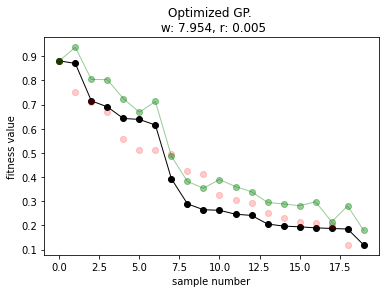

In [7]:

gp = GaussianProcess(kernel_list=kdict, regularization=sdt3,
                     train_fp=std['train'],
                     train_target=train_targets['target'],
                     optimize_hyperparameters=True)
print('Optimized kernel:', gp.kernel_list)
print(-gp.theta_opt['fun'])

# Do the optimized predictions.
optimized = gp.predict(test_fp=std['test'], uncertainty=True)
# Scale predictions back to the original scale.
opt_prediction = np.vstack(optimized['prediction']) * train_targets['std'] + train_targets['mean']
opt_uncertainty = np.vstack(optimized['uncertainty_with_reg']) * train_targets['std']
# Get average errors.
error = get_error(opt_prediction.reshape(-1), fitness_value_test.reshape(-1))
print('Gaussian kernel regression prediction:', error['absolute_average'])
# Get confidence interval on predictions.
# Store the known underlying function for plotting.
linex = np.linspace(np.min([i for i in range(finger_test.shape[0])]), 
                    np.max([i for i in range(finger_test.shape[0])]),
                    len(population_test.pop))
liney = fitness_value_test

plt.figure(0)
plt.plot(linex, liney, 'o-', lw=1, color='black')
plt.plot([i for i in range(finger_train.shape[0])], fitness_value, 'o', alpha=0.2, color='red')
plt.plot([i for i in range(finger_test.shape[0])], opt_prediction, 'o-', lw=1, alpha=0.4,color='green')

plt.title('Optimized GP. \n w: {0:.3f}, r: {1:.3f}'.format(
    gp.kernel_list[0]['width'][0] * stdx,
    np.sqrt(gp.regularization) * stdy))
plt.xlabel('sample number')
plt.ylabel('fitness value')
plt.axis('tight')

## Part 4 GA Mutation

### 4.1 Mutation setting

In [8]:
import numpy as np
from ase.io import write
from ase.ga import get_raw_score
from ase.ga.data import DataConnection
from ase.ga.population import Population
from ase.ga.utilities import closest_distances_generator, CellBounds
from ofp_comparator import OFPComparator
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ
slab = da_cmplt.get_slab()
atom_numbers_to_optimize = da_cmplt.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 0.5)

cellbounds = CellBounds(bounds={'phi': [20, 160], 'chi': [20, 160],
                                'psi': [20, 160], 'a': [2, 60],
                                'b': [2, 60], 'c': [2, 60]})

pairing = CutAndSplicePairing(slab, n_top, blmin, p1=1., p2=0., minfrac=0.15,
                              number_of_variable_cell_vectors=3,
                              cellbounds=cellbounds, use_tags=False)

strainmut = StrainMutation(blmin, stddev=0.7, cellbounds=cellbounds,
                           number_of_variable_cell_vectors=3,
                           use_tags=False)

blmin_soft = closest_distances_generator(atom_numbers_to_optimize, 0.1)
softmut = SoftMutation(blmin_soft, bounds=[2., 5.], use_tags=False)

operators = OperationSelector([4., 3., 3.],
                              [pairing, softmut, strainmut])

comp = OFPComparator(n_top=n_top, dE=1.0, cos_dist_max=5e-3, rcut=10.,
                     binwidth=0.05, pbc=[True, True, True], sigma=0.05,
                     nsigma=4, recalculate=False)
# The population


### 4.2 Mutation recycle

In [9]:
# Test a few new candidates
generations = 10
cand_num=[]
cand_engy=[]
fit = opt_prediction
for _ in range(generations):
    print('Now starting generation {0}'.format(_))
    for step in range(len(population_test.pop)):
        print('Now starting configuration number {0}'.format(step), flush=True)

        # Generate a new candidate
        a3 = None
        while a3 is None:
            a1, a2 = population_test.get_two_candidates(fit, with_history=True)
            a3, desc = operators.get_new_individual([a1, a2])
            print(a3, desc)
        # Relax it and add to database
        da_rlxt.add_unrelaxed_candidate(a3, description=desc)
        a3 = da_rlxt.get_an_unrelaxed_candidate()
        a3.calc = LJ()
        print('Relaxing starting candidate {0}'.format(a3.info['confid']))
        dyn = BFGS(a3, trajectory=None, logfile=None)
        dyn.run(fmax=0.05, steps=1000)
        a3.info['key_value_pairs']['raw_score'] = -a3.get_potential_energy()
        da_rlxt.add_relaxed_step(a3)
        cand_num.append(a3.info['confid'])
        cand_engy.append(a3.get_potential_energy())

        # Update the population
        population_test.update()
        # Update the strain mutation and pairing operators
        if (step) % 10 == 0:
            current_pop = population_test.get_current_population()
            strainmut.update_scaling_volume(current_pop, w_adapt=0.5,
                                            n_adapt=4)
            pairing.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)
            write('current_population_mutate.xyz', current_pop)
        # Print out information for easier follow-up/analysis/plotting:
        print('Step %d %s %.3f %.3f %.3f' % (
            step, desc, get_raw_score(a1), get_raw_score(a2), get_raw_score(a3)))

        print('Step %d highest raw score in pop: %.3f' %
            (step, get_raw_score(current_pop[0])))       
        
    
        for i in range(len(population_test.pop)):
            finger_matrix = comp.take_fingerprints(population_test.pop[i])
            finger = np.append(finger, finger_matrix[0][(6,6)].reshape((1,200)), axis=0)   
        finger_test = np.delete(finger, 1, axis = 0)

        std = standardize(train_matrix=finger_train, test_matrix=finger_test)
        optimized = gp.predict(test_fp=std['test'], uncertainty=True)
        opt_prediction = np.vstack(optimized['prediction']) * train_targets['std'] + train_targets['mean']
        opt_uncertainty = np.vstack(optimized['uncertainty_with_reg']) * train_targets['std']
        # Get average errors.
        fit = opt_prediction

print('GA finished after step %d' % step)
hiscore = get_raw_score(current_pop[0])
print('Highest raw score = %8.4f eV' % hiscore)
write('all_candidates_mutate.xyz', da_rlxt.get_all_relaxed_candidates())
write('current_population_mutate.xyz', current_pop)
print([i for i in range(len(current_pop))])
print([get_raw_score(current_pop[i]) for i in range(len(current_pop))])


Now starting generation 0
Now starting configuration number 0
Atoms(symbols='C38', pbc=True, cell=[[10.350230632555489, 0.0, 0.0], [1.1091955801066828, 5.2160811244332885, 0.0], [1.6813179221304717, -1.2694420864381524, 7.409102907064938]], tags=...) mutation: strain
Relaxing starting candidate 22


/public1/home/scf1054/.local/lib/python3.8/site-packages/ase/io/extxyz.py:302: UserWarning: Skipping unhashable information fingerprints
  warnings.warn('Skipping unhashable information '


Step 0 mutation: strain 156.700 163.688 157.482
Step 0 highest raw score in pop: 180.322
Now starting configuration number 1
Atoms(symbols='C38', pbc=True, cell=[[6.112920118770927, 0.0, 0.0], [-0.2024309924700735, 7.957713622115432, 0.0], [0.3342528941595943, -1.5894695722036152, 8.22286129888302]], tags=...) pairing: 5 9
Relaxing starting candidate 24
Step 1 pairing: 5 9 163.688 180.322 167.907
Step 1 highest raw score in pop: 180.322
Now starting configuration number 2
Atoms(symbols='C38', pbc=True, cell=[[7.7568799123489445, 0.0, 0.0], [-3.7622062654320887, 7.332912439912638, 0.0], [-2.381436224009957, -5.756537774741851, 7.032284366104947]], tags=...) mutation: strain
Relaxing starting candidate 26
Step 2 mutation: strain 158.509 158.233 158.509
Step 2 highest raw score in pop: 180.322
Now starting configuration number 3
Atoms(symbols='C38', pbc=True, cell=[[5.941054189071712, 0.0, 0.0], [1.008277686070381, 16.864838573364572, 0.0], [-2.9938759744880614, -1.1082236664054153, 3.992

[-157.48180489421387, -167.90665152260888, -158.50907865843374, -132.19994385209043, -194.56449039123896, -131.35092920197962, -193.0704353633059, -153.70251908234687, -169.15005634999972, -158.62525259186827, -136.20587239587624, -154.5971023723868, -146.22723875388476, -152.9776190768595, -193.9562630025538, -189.73055066363966, -169.38059562144997, -143.8770475012109, -190.4006615331452, -153.7708673265947, -171.48662536535986, -161.59944687315016, -183.69664385865389, -180.33365041996927, -171.57533302691698, -169.1209808411335, -169.04882318596964, -180.49016702869244, -189.04677868357248, -194.56740357123095, -193.57246311160765, -190.05744489184815, -196.8236573322742, -192.07172546166547, -160.73551898994742, -204.907151389053, -181.03771289403917, -188.07668022507406, -198.10017127828255, -189.54380014717887, -177.54621543403005, -184.720718816178, -196.25670901201596, -196.51676879334337, -199.83734169980076, -198.0276163694031, -169.08523250250929, -191.18192253849125, -197.

Text(0, 0.5, 'Energy')

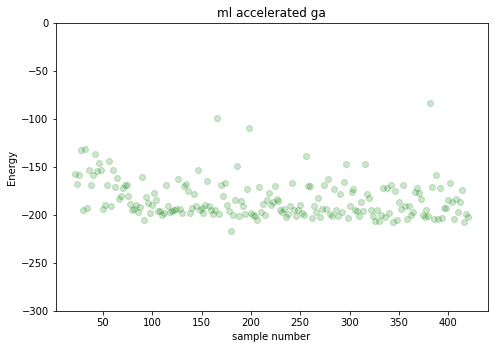

In [10]:
write('highest_raw_score_ml.xyz', current_pop[0])
fig=plt.figure(1)
al=fig.add_axes([0,0,1,1])
al.set_ylim(-300,0)
print(cand_engy)
al.plot(cand_num, cand_engy, 'o', alpha=0.2, color='green')
al.set_title('ml accelerated ga')
al.set_xlabel('sample number')
al.set_ylabel('Energy')

## 5. Conventional GA

In [11]:
import numpy as np
from ase.io import write
from ase.ga import get_raw_score
from ase.ga.data import DataConnection
from ase.ga.population import Population
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.ofp_comparator import OFPComparator
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ

In [12]:

da = DataConnection('gadb_rlxt_ga.db')

# Various items needed for initializing the genetic operators
slab = da.get_slab()
atom_numbers_to_optimize = da.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 0.5)

cellbounds = CellBounds(bounds={'phi': [20, 160], 'chi': [20, 160],
                                'psi': [20, 160], 'a': [2, 60],
                                'b': [2, 60], 'c': [2, 60]})

# Note the "use_tags" keyword argument being used
# to signal that we want to preserve molecular identity
# via the tags
pairing = CutAndSplicePairing(slab, n_top, blmin, p1=1., p2=0., minfrac=0.15,
                              number_of_variable_cell_vectors=3,
                              cellbounds=cellbounds, use_tags=False)

strainmut = StrainMutation(blmin, stddev=0.7, cellbounds=cellbounds,
                           number_of_variable_cell_vectors=3,
                           use_tags=False)

blmin_soft = closest_distances_generator(atom_numbers_to_optimize, 0.1)
softmut = SoftMutation(blmin_soft, bounds=[2., 5.], use_tags=False)

operators = OperationSelector([4., 3., 3.],
                              [pairing, softmut, strainmut])



In [13]:


# The structure comparator for the population
comp = OFPComparator(n_top=n_top, dE=1.0, cos_dist_max=5e-3, rcut=10.,
                     binwidth=0.05, pbc=[True, True, True], sigma=0.05,
                     nsigma=4, recalculate=False)

# The population
population = Population(data_connection=da,
                        population_size=20,
                        comparator=comp,
                        logfile='log.txt')


n_to_test = len(population.pop)
generations = 10
cand_num_ga=[]
cand_engy_ga=[]

for _ in range(generations):
    print('Now starting generation {0}'.format(_))
    for step in range(n_to_test):
        print('Now starting configuration number {0}'.format(step))

        # Create a new candidate
        a3 = None
        while a3 is None:
            a1, a2 = population.get_two_candidates()
            a3, desc = operators.get_new_individual([a1, a2])
            print(a3, desc)
        
        # Relax it and add to database
        da.add_unrelaxed_candidate(a3, description=desc)
        a3 = da.get_an_unrelaxed_candidate()
        a3.calc = LJ()
        print('Relaxing starting candidate {0}'.format(a3.info['confid']))
        dyn = BFGS(a3, trajectory='bfgsdec.xyz', logfile='bfgsdec.txt')
        dyn.run(fmax=0.05, steps=100)
        a3.info['key_value_pairs']['raw_score'] = -a3.get_potential_energy()
        da.add_relaxed_step(a3)
        cand_num_ga.append(a3.info['confid'])
        cand_engy_ga.append(a3.get_potential_energy())
        # Update the population
        population.update()
    

        # Update the strain mutation and pairing operators
        if step % 10 == 0:
            current_pop = population.get_current_population()
            strainmut.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)
            pairing.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)
            write('current_population_ga.xyz', current_pop)

        # Print out information for easier follow-up/analysis/plotting:
        print('Step %d %s %.3f %.3f %.3f' % (
            step, desc, get_raw_score(a1), get_raw_score(a2), get_raw_score(a3)))

        print('Step %d highest raw score in pop: %.3f' %
            (step, get_raw_score(current_pop[0])))  

print('GA finished after step %d' % step) 
hiscore = get_raw_score(current_pop[0])
print('Highest raw score = %8.4f eV' % hiscore)
write('all_candidates_ga.xyz', da.get_all_relaxed_candidates())
write('current_population_ga.xyz', current_pop)
write('Highest_raw_score_ga.xyz', current_pop[0])


Now starting generation 0
Now starting configuration number 0
Atoms(symbols='C38', pbc=True, cell=[[7.471734641067723, 0.0, 0.0], [-5.590147020625136, 3.8608184029065136, 0.0], [6.371214527399753, -0.9442146687447929, 13.866254825945829]], tags=...) mutation: strain
Relaxing starting candidate 42
Step 0 mutation: strain 127.065 142.733 125.166
Step 0 highest raw score in pop: 180.322
Now starting configuration number 1
Atoms(symbols='C38', pbc=True, cell=[[4.546006528476668, 0.0, 0.0], [-0.8639539186781366, 11.879578982384615, 0.0], [5.034214901343622, -3.7285246067924303, 7.406770478711634]], tags=...) mutation: soft
Relaxing starting candidate 44
Step 1 mutation: soft 178.794 158.509 88.032
Step 1 highest raw score in pop: 180.322
Now starting configuration number 2
Atoms(symbols='C38', pbc=True, cell=[[13.077874571952645, 0.0, 0.0], [-2.665655282134447, 2.3933706053953214, 0.0], [-0.5722427112713203, 1.006388075142125, 12.779470820250081]], tags=...) mutation: soft
Relaxing starting

[-125.16553602491082, -88.0322111511085, -142.7329900596141, -156.6858965723177, -128.61593300665467, -133.0422571491394, -145.72684789587453, -145.3581071416641, -163.83178877204287, -127.1910836893728, -145.0971827541447, -140.72233262507095, -178.78080268427038, -148.8010125327692, -141.90015370362212, -151.9312849201041, -114.52309463548379, -160.43883863958862, -132.91907013779098, -142.44091732977014, -164.933109639625, -133.54553153905718, -162.8416535939634, -149.76639690690286, -143.58193398494612, -175.68709990571782, -156.79521124745813, -170.84635781796035, -140.26131437815187, -131.15392648411728, -140.56169451735167, -178.2020131133646, -139.24302944046136, -159.92294336414312, -143.08326881284768, -150.52425718438784, -136.68645124285493, -138.1464384333861, -164.42649234925148, -158.9780567241504, -143.3730427047381, -134.80349651282756, -161.89410591942578, -141.53516742699566, -119.24161316421062, -161.446335886904, -139.63717330772565, -187.23091799256457, -161.44759

Text(0, 0.5, 'Energy')

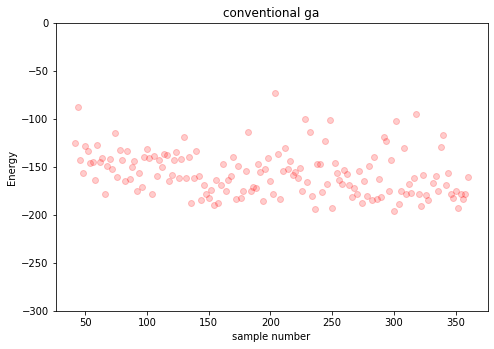

In [14]:

fig=plt.figure(2)
al=fig.add_axes([0,0,1,1])
al.set_ylim(-300,0)
print(cand_engy_ga)
al.plot(cand_num_ga, cand_engy_ga, 'o', alpha=0.2, color='red')
al.set_title('conventional ga')
al.set_xlabel('sample number')
al.set_ylabel('Energy')
